## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import warnings


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



from causallearn.search.ConstraintBased.PC import pc
from sklearn.preprocessing import LabelEncoder


from causallearn.utils.GraphUtils import GraphUtils
import io
import matplotlib.image as mpimg
import graphviz

## Loading the data file

In [3]:
#Opening the feather file


# Load the Feather file into a DataFrame
df = pd.read_csv('mds_data_lst_5_years.csv')


df

,name,longitude,latitude,simDoc,soilCapacity,initialSW,NFert,sowDate,cultivar,pldensity,...,RainSum,RainBeforeFlowering,RainAroundFlowering,RainAfterFlowering,PTQSum,RunOffSum,MaxTAVG,MinTAVG,MeanTAVG,CGRAroundFlowering
0,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,mid,mid,...,14.6,13.4,0.3,0.9,0.881,0.000,25.598,10.907,18.253,37.809
1,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,mid,mid,...,248.7,56.6,62.2,129.9,0.713,39.655,26.014,12.831,19.423,136.407
2,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,mid,mid,...,35.2,17.3,10.8,7.1,0.772,0.000,26.769,11.453,19.111,27.708
3,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,mid,mid,...,34.1,12.8,21.2,0.1,0.849,0.000,26.465,10.480,18.473,54.073
4,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,mid,mid,...,86.6,63.5,22.5,0.6,0.755,0.359,24.899,11.688,18.294,112.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83195,griffith,146.043836,-34.279924,146_-34.3,d,100,300,15-sep,mid,mid,...,120.6,40.3,32.3,48.0,1.292,0.000,29.979,13.934,21.956,62.874
83196,griffith,146.043836,-34.279924,146_-34.3,d,100,300,15-sep,mid,mid,...,96.9,45.9,7.5,43.5,1.252,0.000,29.941,14.029,21.985,82.524
83197,griffith,146.043836,-34.279924,146_-34.3,d,100,300,15-sep,mid,mid,...,182.1,131.6,9.7,40.8,1.257,0.680,27.012,11.871,19.441,163.625
83198,griffith,146.043836,-34.279924,146_-34.3,d,100,300,15-sep,mid,mid,...,193.4,76.2,90.8,26.4,1.212,0.000,29.963,13.786,21.875,125.752


## Check the column types for the dataset 

In [5]:

# Get the data types of all columns
column_data_types = df.dtypes

print(column_data_types)

name                    object
longitude              float64
latitude               float64
simDoc                  object
soilCapacity            object
initialSW               object
NFert                    int64
sowDate                 object
cultivar                object
pldensity               object
SSC_start              float64
SSC_slowstart          float64
year                     int64
yield                  float64
pawc                   float64
EpSum                  float64
EpBeforeFlowering      float64
EpAroundFlowering      float64
EpAfterFlowering       float64
EsSum                  float64
EsBeforeFlowering      float64
EsAroundFlowering      float64
EsAfterFlowering       float64
RadnSum                float64
RadnBeforeFlowering    float64
RadnAroundFlowering    float64
RadnAfterFlowering     float64
RainSum                float64
RainBeforeFlowering    float64
RainAroundFlowering    float64
RainAfterFlowering     float64
PTQSum                 float64
RunOffSu

## Check for uniques values in every column 

In [7]:
#Identify how many unique values each and every columns contain

df.nunique()



name                       9
longitude                  9
latitude                   9
simDoc                     9
soilCapacity               5
initialSW                  4
NFert                      4
sowDate                    6
cultivar                   1
pldensity                  1
SSC_start                  4
SSC_slowstart              1
year                       5
yield                  51193
pawc                      37
EpSum                  46431
EpBeforeFlowering      30998
EpAroundFlowering      33526
EpAfterFlowering       29728
EsSum                  38939
EsBeforeFlowering      22286
EsAroundFlowering      20952
EsAfterFlowering       30417
RadnSum                  257
RadnBeforeFlowering      254
RadnAroundFlowering      246
RadnAfterFlowering       250
RainSum                  251
RainBeforeFlowering      249
RainAroundFlowering      199
RainAfterFlowering       228
PTQSum                   199
RunOffSum               8392
MaxTAVG                  260
MinTAVG       

## Removing unwanted columns that has no variability to provide

In [9]:
# #Removing columns that has uniqueness 1 since it cannot contribute to any variations and therefore cannot contribute to the predictive power of the model

unwanted_columns = ['cultivar', 'pldensity','SSC_slowstart']

# Remove unwanted columns from the dataset
df = df.drop(columns=unwanted_columns)

# Display the first few rows of the cleaned dataset
df.head()


,name,longitude,latitude,simDoc,soilCapacity,initialSW,NFert,sowDate,SSC_start,year,...,RainSum,RainBeforeFlowering,RainAroundFlowering,RainAfterFlowering,PTQSum,RunOffSum,MaxTAVG,MinTAVG,MeanTAVG,CGRAroundFlowering
0,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,500.0,2015,...,14.6,13.4,0.3,0.9,0.881,0.000,25.598,10.907,18.253,37.809
1,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,500.0,2016,...,248.7,56.6,62.2,129.9,0.713,39.655,26.014,12.831,19.423,136.407
2,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,500.0,2017,...,35.2,17.3,10.8,7.1,0.772,0.000,26.769,11.453,19.111,27.708
3,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,500.0,2018,...,34.1,12.8,21.2,0.1,0.849,0.000,26.465,10.480,18.473,54.073
4,emerald,148.165108,-23.511288,148.2_-23.5,base,25top,0,15-apr,500.0,2019,...,86.6,63.5,22.5,0.6,0.755,0.359,24.899,11.688,18.294,112.384


## Check the labels before encoding

In [11]:

soilCapacity_u = df['soilCapacity'].unique()
print(soilCapacity_u)
initialSW_u = df['initialSW'].unique()
print(initialSW_u)
sowDate_u = df['sowDate'].unique()
print(sowDate_u)
simDoc_u = df['simDoc'].unique()
print(simDoc_u)


['base' 'a' 'b' 'c' 'd']
['25top' '50top' '75top' '100']
['15-apr' '15-may' '15-jun' '15-jul' '15-aug' '15-sep']
['148.2_-23.5' '151.3_-27.2' '149_-29' '150.9_-31.1' '149.8_-25.6'
 '149.8_-30.3' '143.9_-35.7' '148.6_-32.2' '146_-34.3']


## Label encoding

In [13]:
# Convert categorical columns to numeric using Label Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))  # Convert columns to string in case there are mixed types
    label_encoders[column] = le

# Check the data to ensure all columns are numeric
print(df.head())



   name   longitude   latitude  simDoc  soilCapacity  initialSW  NFert  \
0     2  148.165108 -23.511288       2             2          1      0   
1     2  148.165108 -23.511288       2             2          1      0   
2     2  148.165108 -23.511288       2             2          1      0   
3     2  148.165108 -23.511288       2             2          1      0   
4     2  148.165108 -23.511288       2             2          1      0   

   sowDate  SSC_start  year  ...  RainSum  RainBeforeFlowering  \
0        0      500.0  2015  ...     14.6                 13.4   
1        0      500.0  2016  ...    248.7                 56.6   
2        0      500.0  2017  ...     35.2                 17.3   
3        0      500.0  2018  ...     34.1                 12.8   
4        0      500.0  2019  ...     86.6                 63.5   

   RainAroundFlowering  RainAfterFlowering  PTQSum  RunOffSum  MaxTAVG  \
0                  0.3                 0.9   0.881      0.000   25.598   
1         

## Checking the column types after label encoding and printing the total number of columns in the dataset 

In [15]:
df


print(df.dtypes)

name                     int32
longitude              float64
latitude               float64
simDoc                   int32
soilCapacity             int32
initialSW                int32
NFert                    int64
sowDate                  int32
SSC_start              float64
year                     int64
yield                  float64
pawc                   float64
EpSum                  float64
EpBeforeFlowering      float64
EpAroundFlowering      float64
EpAfterFlowering       float64
EsSum                  float64
EsBeforeFlowering      float64
EsAroundFlowering      float64
EsAfterFlowering       float64
RadnSum                float64
RadnBeforeFlowering    float64
RadnAroundFlowering    float64
RadnAfterFlowering     float64
RainSum                float64
RainBeforeFlowering    float64
RainAroundFlowering    float64
RainAfterFlowering     float64
PTQSum                 float64
RunOffSum              float64
MaxTAVG                float64
MinTAVG                float64
MeanTAVG

In [17]:
#Checking the total number of columns in the dataset 
num_cols = df.select_dtypes(include=np.number).columns

print(len(num_cols))

print(num_cols)

34
Index(['name', 'longitude', 'latitude', 'simDoc', 'soilCapacity', 'initialSW',
       'NFert', 'sowDate', 'SSC_start', 'year', 'yield', 'pawc', 'EpSum',
       'EpBeforeFlowering', 'EpAroundFlowering', 'EpAfterFlowering', 'EsSum',
       'EsBeforeFlowering', 'EsAroundFlowering', 'EsAfterFlowering', 'RadnSum',
       'RadnBeforeFlowering', 'RadnAroundFlowering', 'RadnAfterFlowering',
       'RainSum', 'RainBeforeFlowering', 'RainAroundFlowering',
       'RainAfterFlowering', 'PTQSum', 'RunOffSum', 'MaxTAVG', 'MinTAVG',
       'MeanTAVG', 'CGRAroundFlowering'],
      dtype='object')


## Standardization and Normalization of data

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the StandardScaler
scaler_standard = StandardScaler()

# Scale the entire dataset
data_scaled_standard = scaler_standard.fit_transform(df)

# Convert the scaled array back into a DataFrame
df_scaled_standard = pd.DataFrame(data_scaled_standard, columns=df.columns)

# Display the scaled dataset using StandardScaler
print("\nScaled dataset (StandardScaler):")
print(df_scaled_standard.head(5))  # Display the first 5 rows

# Initialize the MinMaxScaler
scaler_minmax = MinMaxScaler()

# Normalize the scaled dataset further
data_normalized = scaler_minmax.fit_transform(data_scaled_standard)

# Convert the normalized array back into a DataFrame
data = pd.DataFrame(data_normalized, columns=df.columns)

# Display the normalized dataset using MinMaxScaler
print("\nNormalized dataset (MinMaxScaler):")
print(data.head(5))  # Display the first 5 rows



Scaled dataset (StandardScaler):
       name  longitude  latitude    simDoc  soilCapacity  initialSW     NFert  \
0 -0.773111  -0.209501  1.691754 -0.782679           0.0  -0.447214 -0.987878   
1 -0.773111  -0.209501  1.691754 -0.782679           0.0  -0.447214 -0.987878   
2 -0.773111  -0.209501  1.691754 -0.782679           0.0  -0.447214 -0.987878   
3 -0.773111  -0.209501  1.691754 -0.782679           0.0  -0.447214 -0.987878   
4 -0.773111  -0.209501  1.691754 -0.782679           0.0  -0.447214 -0.987878   

    sowDate  SSC_start      year  ...   RainSum  RainBeforeFlowering  \
0 -1.487638  -1.341641 -1.388889  ... -1.381124            -1.018003   
1 -1.487638  -1.341641 -0.666667  ...  0.838333            -0.354927   
2 -1.487638  -1.341641  0.055556  ... -1.185819            -0.958142   
3 -1.487638  -1.341641  0.777778  ... -1.196248            -1.027212   
4 -1.487638  -1.341641  1.500000  ... -0.698506            -0.249019   

   RainAroundFlowering  RainAfterFlowering    

In [29]:
data



,name,longitude,latitude,simDoc,soilCapacity,initialSW,NFert,sowDate,SSC_start,year,...,RainSum,RainBeforeFlowering,RainAroundFlowering,RainAfterFlowering,PTQSum,RunOffSum,MaxTAVG,MinTAVG,MeanTAVG,CGRAroundFlowering
0,0.250,0.580379,1.000000,0.250,0.5,0.333333,0.0,0.0,0.0,0.00,...,0.018752,0.045118,0.001907,0.003932,0.176101,0.000000,0.490646,0.445425,0.434534,0.054734
1,0.250,0.580379,1.000000,0.250,0.5,0.333333,0.0,0.0,0.0,0.25,...,0.440858,0.190572,0.395423,0.567497,0.000000,0.580074,0.514229,0.568451,0.510484,0.198836
2,0.250,0.580379,1.000000,0.250,0.5,0.333333,0.0,0.0,0.0,0.50,...,0.055896,0.058249,0.068659,0.031018,0.061845,0.000000,0.557029,0.480338,0.490230,0.039971
3,0.250,0.580379,1.000000,0.250,0.5,0.333333,0.0,0.0,0.0,0.75,...,0.053913,0.043098,0.134774,0.000437,0.142558,0.000000,0.539796,0.418121,0.448815,0.078504
4,0.250,0.580379,1.000000,0.250,0.5,0.333333,0.0,0.0,0.0,1.00,...,0.148576,0.213805,0.143039,0.002621,0.044025,0.005251,0.451020,0.495364,0.437196,0.163726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83195,0.375,0.292514,0.117162,0.125,1.0,0.000000,1.0,1.0,1.0,0.00,...,0.209881,0.135690,0.205340,0.209699,0.606918,0.000000,0.739002,0.638979,0.674911,0.091367
83196,0.375,0.292514,0.117162,0.125,1.0,0.000000,1.0,1.0,1.0,0.25,...,0.167147,0.154545,0.047680,0.190039,0.564990,0.000000,0.736848,0.645054,0.676793,0.120085
83197,0.375,0.292514,0.117162,0.125,1.0,0.000000,1.0,1.0,1.0,0.50,...,0.320772,0.443098,0.061666,0.178244,0.570231,0.009947,0.570805,0.507066,0.511652,0.238616
83198,0.375,0.292514,0.117162,0.125,1.0,0.000000,1.0,1.0,1.0,0.75,...,0.341147,0.256566,0.577241,0.115334,0.523061,0.000000,0.738095,0.629516,0.669653,0.183264


## Removing the outliers

In [32]:
import pandas as pd

def remove_outliers_from_columns(df, cols, factor=1.5):
    """
    Remove outliers from multiple numerical columns using the Interquartile Range (IQR) method.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        cols (list): List of column names to remove outliers from.
        factor (float, optional): Factor to use for determining the outlier range. Default is 1.5.

    Returns:
        pandas.DataFrame: The DataFrame with outliers removed from the specified columns.
    """
    cleaned_df = df.copy()

    for col in cols:
        q1 = cleaned_df[col].quantile(0.25)  # Calculate the first quartile (Q1)
        q3 = cleaned_df[col].quantile(0.75)  # Calculate the third quartile (Q3)
        iqr = q3 - q1  # Calculate the Interquartile Range (IQR)

        # Calculate the lower and upper bounds for outlier detection
        lower_bound = q1 - (factor * iqr)
        upper_bound = q3 + (factor * iqr)

        # Remove outliers from the column
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

    return cleaned_df

# Example usage
# Assuming your DataFrame is called 'data'
# Remove outliers from the specified columns
cols_to_clean = ['yield', 'pawc', 'EpSum', 'EpBeforeFlowering', 'EpAroundFlowering', 'EpAfterFlowering', 'EsSum', 'EsBeforeFlowering', 'EsAroundFlowering', 'EsAfterFlowering', 'RadnSum', 'RadnAfterFlowering', 'RainSum', 'RainBeforeFlowering', 'RainAroundFlowering', 'RainAfterFlowering', 'PTQSum', 'CGRAroundFlowering']
data = remove_outliers_from_columns(df, cols_to_clean)


## Causal discovery

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import FisherZ


import sys
import io
from causallearn.score.LocalScoreFunction import local_score_BDeu
from causallearn.utils.GraphUtils import GraphUtils
sys.path.append("")
import unittest
import warnings
from pickle import load
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83200 entries, 0 to 83199
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 83200 non-null  int32  
 1   longitude            83200 non-null  float64
 2   latitude             83200 non-null  float64
 3   simDoc               83200 non-null  int32  
 4   soilCapacity         83200 non-null  int32  
 5   initialSW            83200 non-null  int32  
 6   NFert                83200 non-null  int64  
 7   sowDate              83200 non-null  int32  
 8   SSC_start            83200 non-null  float64
 9   year                 83200 non-null  int64  
 10  yield                83200 non-null  float64
 11  pawc                 83200 non-null  float64
 12  EpSum                83200 non-null  float64
 13  EpBeforeFlowering    83200 non-null  float64
 14  EpAroundFlowering    83200 non-null  float64
 15  EpAfterFlowering     83200 non-null 

## 1. Peter Clark (PC)  Algorithm

  0%|          | 0/34 [00:00<?, ?it/s]

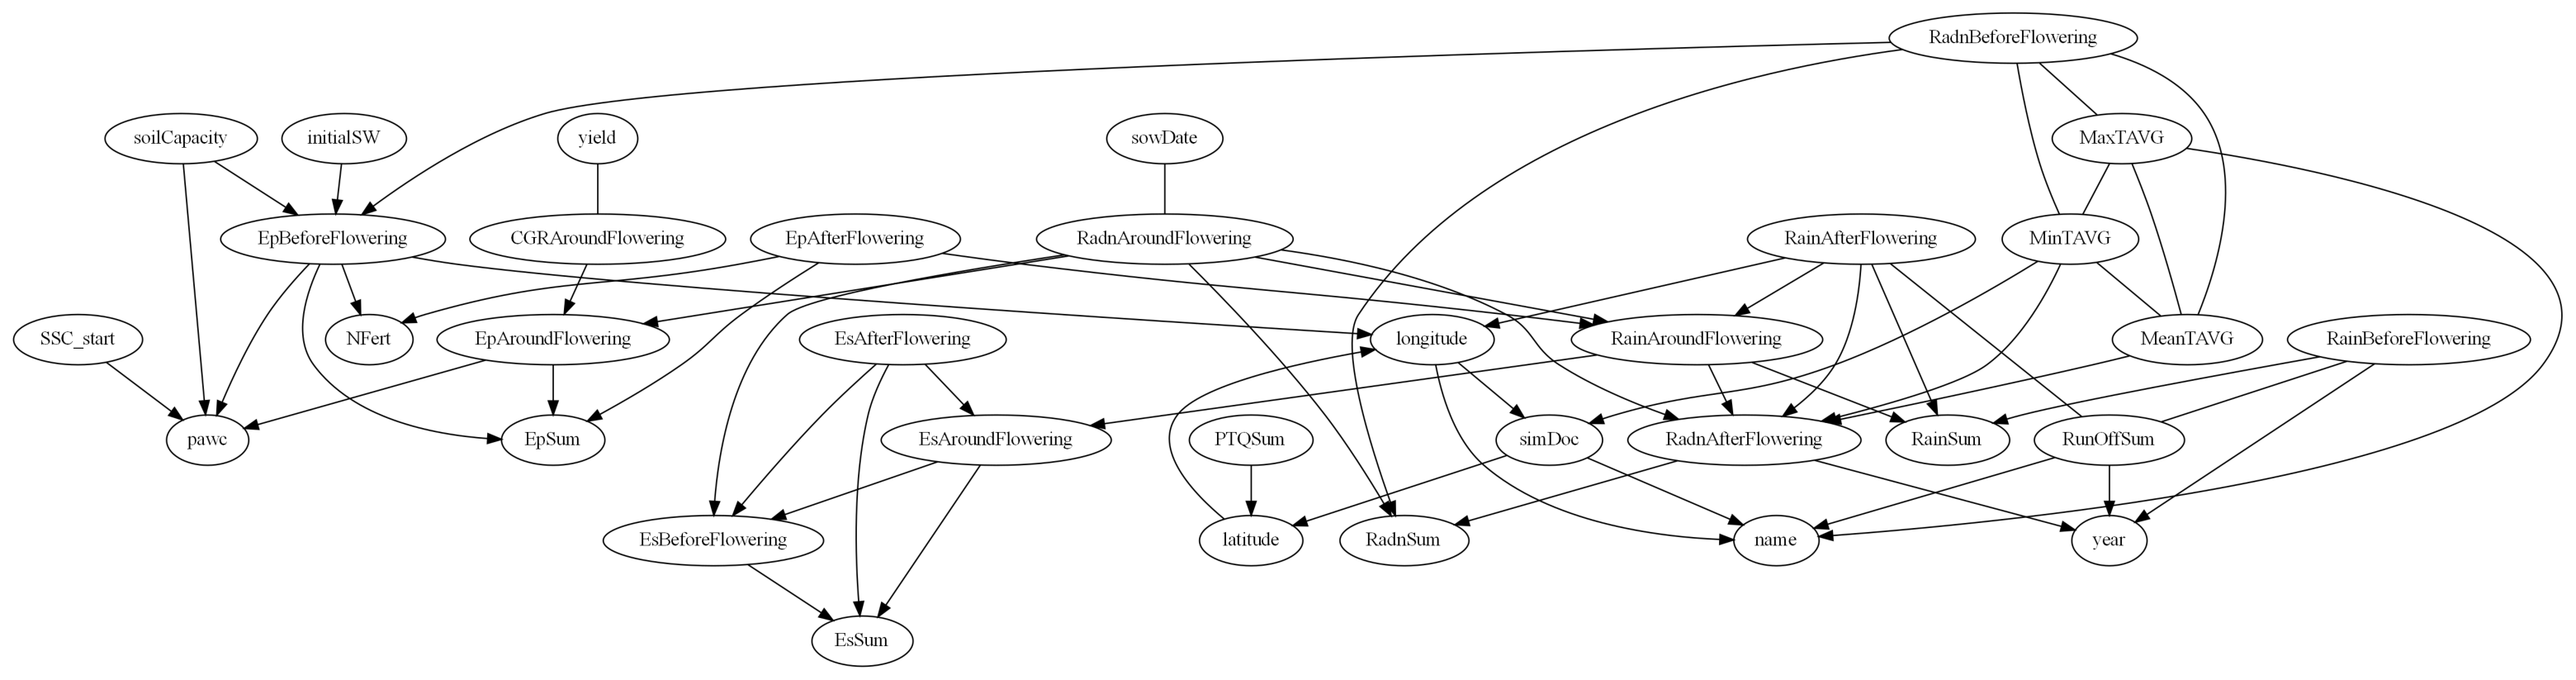

In [29]:
#PC ALgorithm

df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling them with the mean of each column
df = df.fillna(df.mean())

# Verify that there are no NaNs left
assert not df.isnull().values.any(), "DataFrame still contains NaNs"

labels = [f'{col}' for i, col in enumerate(df.columns)]
data = df.to_numpy()

cg = pc(data)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')



plt.figure(figsize=(40, 40)) 
plt.axis('off')
plt.imshow(img)
plt.show()


# Save the image to a file
plt.imsave('causal_graph_PC.png', img)

## 2. GES using BIC score of PCA reduced dataset 

## Performing PCA 

PCA (Principal Component Analysis) is performed on the standardized data X_scaled with n_components=8, which means the analysis reduces the data to 8 principal components.
PCA is a dimensionality reduction technique that transforms the original features into a set of linearly uncorrelated variables (principal components), ordered by the amount of variance they explain in the data.




In [32]:


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = df.drop(columns=['yield'])
y = df['yield']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = 8
# Performing PCA
pca = PCA(n_components=n_components)  # Change n_components to the desired number of principal components
X_pca = pca.fit_transform(X_scaled)

labels = [f'PC {i+1}' for i in range(n_components)]
# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=X_pca, columns=labels)
pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)


# Explained variance ratio
explained_variance = pca.explained_variance_ratio_ #total variance in the data is captured by each principal component.
print(f'Explained variance by each component: {explained_variance}') #total variance in the data is captured by each principal component.
print(f'Total explained variance: {np.sum(explained_variance)}')  #sum of the explained variance ratios 

Explained variance by each component: [0.18904798 0.17915242 0.10270627 0.08938373 0.05471196 0.04517609
 0.04270333 0.03709591]
Total explained variance: 0.7399776858072971


**Interpreting the Output**

Explained variance by each component:

[0.18904798, 0.17915242, 0.10270627, 0.08938373, 0.05471196, 0.04517612, 0.04270331, 0.03709589] </BR>
These values represent the proportion of the total variance in the original dataset that is explained by each of the first 8 principal components.

PC 1 (first principal component) explains about 18.9% of the variance.
PC 2 explains about 17.9% of the variance.
PC 3 explains about 10.3% of the variance.
... and so on.
Each subsequent principal component explains less variance than the previous one.

**Total explained variance: 0.7399776748465301**

This indicates that the first 8 principal components together explain about 73.99% of the total variance in the original dataset.
PCA has reduced the dataset from its original number of features to 8 principal components while retaining approximately 74% of the variance. This means that a significant portion of the information from the original dataset is preserved in these 8 components.



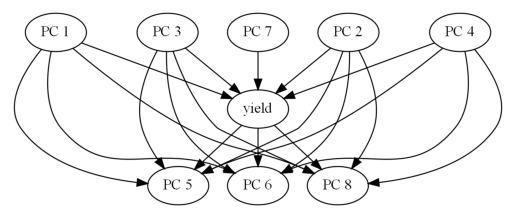

In [37]:
#GES

from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
import io
import pydot


from sklearn.preprocessing import MinMaxScaler
from causallearn.search.ScoreBased.GES import ges

imp_feature = labels + ['yield']

# default parameters
Record = ges(pca_df)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'],labels=imp_feature) #, labels=labels
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

